# Executive Summary

Two analyses I've read of Dream's recent speedrunning performance have been flawed. I believe I can do better, and so I've done my own analysis. $\dots$

# Introduction

## Motivation

I first became aware of the situation via [a blog I follow](https://statmodeling.stat.columbia.edu/2020/12/24/dream-investigation-results-official-report-by-the-minecraft-speedrunning-team/). As someone who has watched some of Dream's video content and is casually addicted to Minecraft, I was drawn to read the Minecraft Speedrunning Team's [report](https://mcspeedrun.com/dream.pdf). It is very well written, in my opinion, and the team behind it has put a lot of time and effort into creating a thorough investigation. Nonetheless, it made several assumptions I do not think are warranted, assumptions that create fundamental problems with the analysis it presented.

That same blog post pointed me towards a [rebuttal report](https://drive.google.com/file/d/1yfLURFdDhMfrvI2cFMdYM8f_M_IRoAlM/view), which had been declared "[hilariously bad](https://statmodeling.stat.columbia.edu/2020/12/24/dream-investigation-results-official-report-by-the-minecraft-speedrunning-team/#comment-1622865)" and riddled with "[absurd errors](https://www.reddit.com/r/statistics/comments/kiqosv/d_accused_minecraft_speedrunner_who_was_caught/ggse2er/?utm_source=reddit&utm_medtook%20time%20to%20review%20theium=web2x&context=3)." My primary critiques of the MST's report were not present, surprisingly, which drew me to read the rebuttal. It also made some faulty assumptions, and again some of what I considered to be the most important ones were missed by the critiques. While not perfect by any means, it was better than I was led to believe.

I asked myself if I could create a better report. After some thought, I realized the analysis was quite similar to others I've done in the past, and so I started work on what you are currently reading.

## Declaration of Bias

I am a graduate student in computer science, specializing in computer graphics. I have not taken a university-level statistics course, though I have taken two courses on cryptography and information theory, and those subjects rely heavily on probability. Neither taught me anything new about probability; my interest in algorithms and philosophy have led me to casually study the statistics underlying science. I've found that self-study to be of immense use, as all my research has relied on statistical analysis at some level. At best, I can be considered an amateur statistician.

My plan to compensate for my lack of authority is to be more detailed and open. I am not anonymous, I can easily be found online via my pen name. I will walk through all the math I employ, and explain my analysis and logic as I go. Not only is all the code I used available [via GitHub](https://github.com/hjhornbeck/bayes_speedrun_cheating/) under the [GNU Public License 3.0](https://github.com/hjhornbeck/bayes_speedrun_cheating/blob/main/LICENSE), it is present in this document as well. You can edit and replay both the simulations and analysis [via a web browser](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb), with the simple click of this button:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/hjhornbeck/bayes_speedrun_cheating/blob/main/did_dream_cheat.ipynb)

**I have not been paid by Dream to write this report, directly or indirectly. I have not been contacted by him or any third party, let alone asked to write this report.** I have enjoyed watching some of his videos, and I believe he is a very talented Minecraft player, but I am indifferent to whether or not his speed runs are considered valid.

**By the same token, I have no relationship with the Minecraft speedrunning community. None of them have contacted or paid me to write this report, directly or via a third party.** I have no plans on becoming a Minecraft speed runner, I'm content to merely build things and do some casual streaming.

My motivations for writing this report can be boiled down to this:

1. [I hate p-values](https://www.google.com/search?q=p-values+site%3Afreethoughtblogs.com%2Freprobate).
2. [I enjoy working with conjugate priors](https://freethoughtblogs.com/reprobate/2020/02/19/dear-bob-carpenter/).

As you'll see, that gives me enough knowledge to critique both reports and generate my own analysis.

# A Critique of the Reports

## Minecraft Speedrunning Team

The [MST report](https://mcspeedrun.com/dream.pdf) is quite good. The authors go into extensive detail on the mechanics of how Blaze rod and Pigmen drops work, to the point of analyzing how random numbers are generated within Minecraft. They compare Dream's performance to other runners, which is vital to help rule out flaws in your analysis. If the analysis shows *all* of the top players are cheating, then either cheating is rampant or something is wrong with your analysis. The report goes into quite a bit of detail into the methods used, and shares code to help with reproducibility. I believe it is a good attempt to "present \[an\] unbiased, rigorous statistical analysis of the data" (pg. 4).

The biggest flaw with the report is the reliance on p-values to generate its conclusions. I have summarized [many critiques of that statistic elsewhere](https://freethoughtblogs.com/reprobate/2015/12/17/index-post-p-values/), but two points are worth covering here.

### P-values are Not What You Think

This is the definition of the p-value:

> If we assume the null hypothesis is true, and draw an infinite amount of data according to what that hypothesis predicts, how often is the test metric applied to that data calculated to be equal to or more extreme than the test metric calculated on the data we observed?

On its surface, it's a very strange metric. Why are we basing our decision on data we have not and will never observe? What counts as "extreme"? The core logic relies on both [modus tollens](https://mathworld.wolfram.com/ModusTollens.html)\footnote{If A is true, B is true; B is false; ergo A is false.} and [the central limit theorem](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Probability/BS704_Probability12.html)\footnote{The means of sufficiently large samples taken from a larger population will follow a Gaussian distribution centred at the population mean.}, which are usually correct but not always so.\cite{cohen_earth_1994,vanderplas_frequentism_2014} 

P-values are not a probability of the null hypothesis being incorrect and cannot be treated as such, yet the MST report declares their final p-value to be an "upper bound on the chance" of Dream getting that lucky (pg. 22). The text which popularized the p-value encourages this mistake.

> When a number of quite independent tests of significance have been made, it sometimes happens that although few or none can be claimed individually as significant, yet the aggregate gives an impression that the probabilities are on the whole lower than would often have been obtained by chance. It is sometimes desired, taking account only of these
probabilities, and not of the detailed composition of the data from which they are derived, which may be of very different kinds, to obtain a single test of the significance of the aggregate, based on the product of the probabilities individually observed. (pg. 103)\cite{fisher1934statistical}

It is often not clear that Sir Ronald Fisher is talking about the odds of calculating a test statistic more extreme than data generated according to the null hypothesis, rather than the odds of the null hypothesis being true. Few people understand the p-value, and even experts can misinterpret it.

> In a recent survey of medical residents published in JAMA, 88% expressed fair to complete confidence in interpreting P values, yet only 62% of these could answer an elementary P-value interpretation question correctly. However, it is not just those statistics that testify to the difficulty in interpreting P values. In an exquisite irony, none of the answers offered for the P-value question was correct $\dots$ \cite{goodman_dirty_2008}

### P-values Exaggerate the Evidence

Multiple studies have looked into the predictive power of p-values by simulating experiments.\cite{hubbard_why_2008,colquhoun2014investigation,halsey_fickle_2015} These should be taken with a grain of salt, as many of them argue p-values exaggerate the evidence relative to Bayesian methods. If you believe hypotheses can only be true or false, and cannot be assigned probability values, then you believe Bayesian methods are invalid and thus cannot be used as a reference. Not all of these simulation studies use that reference, however.

> In this article, I investigate p-values in relation to replication. My conclusion is that, if you repeat an experiment, you are likely to obtain a p-value quite different from the p in your original experiment. The p-value is actually a very unreliable measure, and it varies dramatically over replications, even with large sample sizes. Therefore, any p-value gives only very vague information about what is likely to happen on replication, and any single p-value could easily have been quite different, simply because of sampling variability.\cite{doi:10.1111/j.1745-6924.2008.00079.x}

The evidence has become strong enough that some researchers have proposed lowering the traditional p-value cut-off of 0.05 to a lower value.\cite{Johnson19313} The theory is that rather than asking scientists to abandon the use of p-values, it is simpler to compensate by lowering the threshold for significance and thus increasing the amount of evidence required to reach that bar. Some fields of science have already made that transition, for instance particle physics and genomics research often require $p < 0.0000003$. If p-values exaggerate the evidence against the null hypothesis, and the null hypothesis is that Dream's drop rate was unmodified, then by using p-values the MST report is exaggerating the evidence against Dream. This alone makes another report worthwhile.

I have other complaints about the MST report, but there's significant overlap between them and what's in the Photoexitation report.

## Photoexcitation

The PE report offers a few good critiques. It argues that since Minecraft speedrunners almost always stop after they've earned k items, instead of stopping after n trades/drops, the resulting k and n do not follow the binomial distribution. The MST report does not consider this. As my later analysis will show, this does have a significant impact on the probabilities. I also agree that the last game Dream played in the analysis should be treated differenly than the last, due to the same logic that led me to conclude trades/drops do not follow the binomial distribution.

The PE report's decision to use Bayesian statistics was correct, as in my opinion it copes better with small sample sizes than frequentist methods such as the p-value. It also used simulations to examine the relevant mechanics of Minecraft, a wise choice that makes it easier to examine different possible outcomes in a controlled environment.

### Misunderstanding Minecraft

However, the PE report demonstrates some misunderstandings about how Minecraft is played.

> If you consider every Minecraft player, then a ”perfect” ender pearl and blaze drop record (2/2 ender pearl barters and 7/7 blaze rod drops) occurs multiple times per hour, since this has a 1 in 60000 odds and Minecraft is played many millions of times a day. Considering all Minecraft worlds ever played and the multitude of ways in which luck plays a role, even one in a trillion events happen daily.

I am a Minecraft player. While I haven't tracked my Ender pearl trade stats, I can state with confidence that of the zero attempts I'm made to earn Blaze rods, zero have been successful. This is because I have no interest in reaching "The End" at the moment, nor have I had the inclination in the six months or so I've been playing this game. If that did change, I'm playing on a private server with other people who have long since tracked down a stronghold on our shared map and set up a minecart route to it. In practice, gathering the materials to make an Eye of Ender is something most Minecraft players rarely do, and when they attempt it is only rarely done more than once the entire time they play Minecraft. Only a very small fraction of the Minecraft community attempts to speedrun the game, and only those players routinely hunt for Ender pearls and Blaze rods. One in a trillion events can happen daily, but only if about a trillion attempts are made at those events per day.

This lack of knowledge is understandable, given the author does not appear to be a Minecraft player. Nonetheless, the more you know about a topic the more likely any analysis of that topic will rest on false premises.

### Lack of a Comparison to Real World Data

This premise leads the PE report to forgo comparisons to other speedrunners.

> Comparison to other runners is not necessary to establish that Dream had very low probability runs. Instead this comparison is more relevant to the interpretation of these low probabilities. For example, it reduces the plausibility that the low probabilities were due to some universal glitch that affects all speedrunners. As the reader is assessing the evidence, the low probability of Dream’s runs and that Dream performed much better than other speedrunners should not be considered as independent pieces of evidence as they both are consequences of the same thing. Any lucky speedrunner chosen because they look lucky will look lucky when compared to other speedrunner
streams that were chosen randomly.

At the core of statistics is the idea of [a reference class](https://en.wikipedia.org/wiki/Reference_class_problem):. By invoking every Minecraft player, the PE report is stating that Dream's performance should be compared to them, or in other words that they are the appropriate class of entities to use as a reference. Here, though, the report argues that Dream's performance should not be compared to that of other top speed runners, because it is too dissimilar and therefore makes a poor reference class.

Setting aside the argument that this is the reverse of reality, it is notable that the report makes no attempt to compare Dream's performance to any real-world reference class. If a perfect Blaze rod and Ender pearl bartering session is indeed a common occurance, it should be easy to demonstrate that by pointing to a few examples of ordinary Minecraft players acheiving those feats. Even if they are rarely recorded, discussion of such events must appear in comment sections or Discord channel messages, and we would expect it to be common knowledge among players of Minecraft.

Conversely, even if other speedrunners are an inappropriate reference class, running their performance through the report's simulation would be a valuable check that it is working properly. This is why scientific studies usually have control groups, as they are a validation of the methodology. The author of this report had the data to do this, thanks to the MST report, and passing it through their simulation was as easy as editing two lines of code, so there was no lack of means or opportunity.

### Missing Context

> In this document, I don’t have time to discuss the long-term debate between these different statistical
paradigms and when they should be applied. The short version is that another way of investigating whether
the probabilities were modified is to try to determine what probabilities were used. (pg. 5)

By skipping the details, the PE report leaves out an important consequence of using Bayesian statistics. You can simplify Bayesian stats down to

> Given the data before me, what credence do I place on a hypothesis relative to some reference?

"Credence" can be thought of in terms of "belief points:" when I say I give 100:1 odds that Joe Biden will become President of the United States, I am saying that for every one belief point I give to the hypothesis "Joe Biden will not become President" I also give one hundred towards "Joe Biden will become president."\footnote{The comparison to betting odds is no accident, the study of statistics began with people trying to figure out either how to cheat at gambling or how to detect said cheating.\cite{doi:https://doi.org/10.1002/0471667196.ess0845.pub3}}

Mathematically, "credence" is the output of a [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function). Likelihoods obey all the same rules as probabilities, save one: while probabilities are bounded to stay between 0 and 1, likelihoods only have a lower bound of zero. The inputs to a likelihood function are the data we observe, as well as parameters used to describe a model of our belief in that data. These parameters form a multi-dimensional parameter space. All hypotheses we can make about the data live within that space. These may be point hypotheses ("Dream's Blaze rod drop rate was precisely 0.509583957"), or composite hypotheses that are a weighted subset of all possible point hypotheses ("Dream's Blaze rod drop rate ranged between 0.45 and 0.55"). If the parameter space is discrete ("which side of a six-sided die will appear"), that weighted subset is calculated by summation over all possible parameters; if it is continuous ("Dream's Blaze rod drop rate"), it is calculated by integration over all parameters.

Unfortunately, calculating those integrals directly is impractical for all but the easiest problems. Frustrated statisticians and mathematicians began looking for shortcuts and alternatives, and a number of them were codified into what we now call frequentist statistics. The p-value is one such example: it also relies on likelihood functions, but it assumes the amount of data collected is practically infinite. This allows the problem to be transformed via the central limit theorem into another that's much easier to integrate.

This has an important side-effect: the flip-side of p-values exaggerating the evidence is that Bayesian metrics are relatively conservative when given the same evidence. if the default hypothesis is some variation of "did Dream play fair?", then Bayesian statistics will be slower to give up on that than frequentist statistics. To put that in bold:

**Bayesian statistics is intrinsically more likely to conclude Dream played fairly, relative to frequentist statistics, given the same evidence.** Whether this is a problem or not depends on how sound you think the premises are behind each system. If you think hypotheses can only be true or false, and cannot have probabilities assigned to them, then you reject Bayesian statistics outright. It's not unfair to invoke p-values if the "fairer" analysis begins with "assume five angels can dance on a pinhead...". By the same token, a Bayesian analysis of Dream's performance is not biased towards him relative to one that uses p-values, provided you think p-values should not be applied to this problem.

### Biased Priors

You can think of a prior as a likelihood function supplied with zero evidence. It is convenient to define your likelihood function as how your credence changes given one atom of data, because then you can chain together arbitrary numbers of likelihood functions to handle arbitrary amounts of evidence. That chain has to be anchored somewhere, though, so you also need to define the likelihood of a specific choice of parameters absent any evidence. The opposite end of that chain is the posterior, or your credence after accounting for all the evidence.

Some priors are hypothesis-specific. "What are the odds that Dream cheated?" depends on "what are the odds of a speedrunner cheating?". If cheating is common in the speedrunning community, then the odds of a specific speedrunner cheating are high, absent any evidence that could change the odds of Dream cheating. Likewise, the odds of a specific speedrunner cheating are low if speedrunners in general rarely cheat, again absent any evidence leading us to one conclusion or another.

Some priors apply to all hypotheses. Regardless of whether or not Dream was cheating, what are the odds of him earning 423 Ender pearls after 423 trades? It must be lower than the odds of him having 20 pearls after 423 trades. The odds of earning 40 Ender pearls, or any number between 20 and 423, must be somewhere between those two reference points.

> For those savvy in Bayesian statistics, I use a flat/uniform/tophat prior on the probability boost from
1 to 5 and confirmed that these limits do not significantly affect the interpretation. In this case, this just
means calculating the likelihoods on a grid from 1 to 5 and, since the prior is flat, these are equivalent to the
relative posterior probabilities. This prior does not include any corrections for biases or any opinion that
Dream modified his probabilities. (pg 10)

The prior used in the PE report gives as much credence to Dream earning 20 pearls after 423 trades as it does him earning 100. This is going to exaggerate the likelihood that Dream cheated in the resulting analysis.

The Minecraft Speedrunning Team has [responded to the PE report](https://mcspeedrun.com/dream/rebuttal.pdf). The best critique it makes mirrors one of mine.

> Moreover, their estimation of 300 livestreamed runs per day over the past year is highly implausible. Many runs are not livestreamed, and the estimation is based on current numbers, even though Minecraft speedrunning has grown massively in the recent months. 

> At the time of Dream’s run, there were 487 runners who had times in 1.16 - far under 1000 - and the vast majority of these were unpopular or did not stream. Selection bias could only be induced from observed runners, so speedrunners who had no significant viewership watching their attempts should not be included. (pg. 3)

The remaining critiques have no relevance to my own, and do not need to be discussed here.

# Methodology

Given the flaws in both reports' methodology, it is fair to ask what a better one looks like. Some of what follows repeats what is in another report, but it is critical enough to be worth inclusion anyway.

## The Binomial and Negative Binomial Distributions

As the MST report shows, when a Blaze is killed it can either drop one Blaze rod, or drop zero, and both outcomes are equally likely to happen. The number dropped can increase if the player has enchantments on their weapon, but that almost never happens during a speed run. Blaze rod drops behave like a Bernoulli process:

1. Some algorithm or thing will "emit" one of two possible outputs, canonically labelled 0 and 1.
2. Which of the two outputs is generated cannot be predicted beforehand.
3. The current output does not depend on what's been generated before or will be generated later.
4. As the number of values emitted becomes arbitrarily large, the ratio of zeros to ones comes arbitrarily close to a fixed value. That value does not change if we discard an arbitrary number of those outputs.

We can easily simulate that behaviour ourselves. Suppose I decided to collect some Blaze rods for the first time, and set out to kill six Blazes. To get an idea of how many rods I'd earn, I repeat the process five times.

In [41]:
# Uncomment this line to install all dependencies locally
# !pip install --user ipypublish mpmath numpy pandas matplotlib scipy

from fractions import Fraction

from ipypublish.scripts import nb_setup

from math import comb,log,factorial
import matplotlib.pyplot as plt
from mpmath import mp
import numpy as np

pd = nb_setup.setup_pandas(escape_latex=False) # allow LaTeX in Panda's cells
from scipy.stats import beta,binom,nbinom

dpi = 200    # change this to increase/decrease the resolution charts are made at

In [26]:
# allow for perfect replication by fixing the seed
random  = np.random.default_rng(8)

n = 6     # number of Blazes killed
N = 5     # number of times to kill n Blazes

for experiment in range(N):
    results = random.choice( 2, size=n )
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results]
    print( f"   total = {sum(results)}/{n}" )

[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [ nothing ]    total = 2/6
[Blaze rod] [Blaze rod] [Blaze rod] [Blaze rod] [ nothing ] [ nothing ]    total = 4/6
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ]    total = 1/6
[Blaze rod] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod] [ nothing ]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod]    total = 2/6


Naively, I might calculate my odds of getting exactly three rods by multiplying the odds of getting a rod (50\%) by itself three times, then multiply that by the odds of not getting a rod (50\%) three times. If I carry on that logic for all other possible outcomes and total them up, however, I find the total probability of all outcomes is $7 \cdot (\frac 1 2)^6 = \frac{7}{64}.$ That is not a valid probability distribution over k, because it fails to sum to one.

The error in that logic is that I've failed to account for the number of identical outcomes. Two of the five runs shown above have two successes, but both are arranged in a different way. Had one of my runs gotten a Blaze rod from every Blaze, though, there would be only one way to arrange each success. To correctly calculate the probability of k drops when killing n Blazes, I would need a formula like

$$ (\text{Number of ways to earn k Blaze rods}) \cdot (\text{Odds of getting k Blaze rods, ignoring order}) $$

That formula defines what is known as the Binomial distribution.

\begin{equation}
\text{Binom}(n, k, p) = {n \choose k} p^k (1-p)^{n-k} = \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k}, \label{eqn:binomial}
\end{equation}

where n is the number of times the Bernoulli process is sampled, k is the number of 1's emitted, p is the probability of that Bernoulli process emitting a 1, and "!" is the factorial function. For my toy example above, we find the odds for $n = 6$, $k = 3$, and $p = \frac 1 2$ are not $\frac 7 {64}$ but instead $\frac 5 {16}$. If we were to carry that on for all seven possible values of k and sum the probabilities, they would indeed add up to one.

In [23]:
def binomial( n, k, p ):
    return Fraction(factorial(n), factorial(k)*factorial(n-k)) * (p**k) * ((1-p)**(n-k))

n = 6
p = Fraction(1,2)

total = sum( binomial(n, k, p) for k in range(n+1) )
print( f'The sum of probabilities of all possible k is {total}', end='' )
if total == Fraction(1,1):
    print( ', which means Binom(n,k,p) defines a probability distribution over k.')
else:
    print( '.' )

The sum of probabilities of all possible k is 1, which means Binom(n,k,p) defines a probability distribution over k.


Suppose I make one tweak to the above scenario, though. I would now like to earn three Blaze rods to match three Ender pearls I have in my inventory. The number of Blazes I have to kill is now irrelevant.

In [25]:
random  = np.random.default_rng(15)

k = 3     # number of Blazes rods needed
N = 5     # number of times to kill n Blazes

for experiment in range(N):
    results = random.choice( 2, size=16 )
    if np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    length = np.sum( np.cumsum( results ) < k ) + 1
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results[:length]]
    print( f"   total = {k}/{length}" )

[Blaze rod] [Blaze rod] [Blaze rod]    total = 3/3
[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/6
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/8
[ nothing ] [Blaze rod] [Blaze rod] [Blaze rod]    total = 3/4
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [ nothing ] [Blaze rod]    total = 3/7


Whereas before my last kill of each run may have given me a Blaze rod or may not, now all of my final kills earn me a Blaze rod. The number of combinations has changed from the Binomial case. Let's replay the same sequence of events, only this time we disregard the final kill that earned the final Blaze rod.

In [31]:
random  = np.random.default_rng(15)

k = 3     # number of Blazes rods needed
N = 5     # number of times to kill n Blazes

for experiment in range(N):
    results = random.choice( 2, size=16 )
    if np.sum(results) < k:
        results = np.append( results, random.choice( 2, size=16 ) )
    length = np.sum( np.cumsum( results ) < k )       # note the missing subtraction
    [print("[Blaze rod] ", end='') if x==1 else print("[ nothing ] ", end='') for x in results[:length]]
    print( f"   total = {sum(results[:length])}/{length}" )

[Blaze rod] [Blaze rod]    total = 2/2
[Blaze rod] [ nothing ] [ nothing ] [Blaze rod] [ nothing ]    total = 2/5
[ nothing ] [ nothing ] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [Blaze rod]    total = 2/7
[ nothing ] [Blaze rod] [Blaze rod]    total = 2/3
[Blaze rod] [ nothing ] [ nothing ] [ nothing ] [Blaze rod] [ nothing ]    total = 2/6


Our "last" kill is no longer guaranteed to earn a Blaze rod. Intuitively you'd guess these clipped sequences follow the Binomial distribution, and in this case your intuition is correct. By definition, each event emitted by the Bernoulli distribution is independent of all others, so as of the n-1-th event we'd have no indication the n-th event would earn us our k-th Blaze rod and we'd stop the sequence.

You can see that from the formula for the Negative Binomial distribution, which applies when k is our stopping metric and not n.

\begin{equation}
\text{NegBinom}(n,k,p) = {n-1 \choose k-1} p^k (1-p)^{n-k} = p \cdot \text{Binom}(n-1,k-1,p) \label{eqn:negbinom}
\end{equation}

## Conjugate Priors

This relation between the Negative Binomial and Binomial is incredibly useful.

Remember when I mentioned during the introduction that calculating the integrals necessary for Bayesian statistics "is impractical for all but the easiest problems?" Here's one exception: suppose we wish to calculate our credence for the average of a random variable that's distributed according to the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). The likelihood function in this case is also a Gaussian distribution. If our prior credence for the average also follows a Gaussian distribution, then our posterior is also a Gaussian distribution. Even better, we can treat the posterior as if it was a prior, apply another Gaussian as a likelihood function to represent new data, and get back another Gaussian posterior that incorporates both the old and new data. Best of all, the mean and standard deviation of the Gaussian posterior don't require a sophisticated computer to compute, a calculator or ever a piece of paper is usually enough.

When the prior and posterior of a model follow the same distribution, after applying a consistent likelihood function, that prior is called a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). These are oases of easy calculation in what is otherwise a Bayesian wasteland of tangled computations. If we can find one applicable here, our analysis will be immensely simpler. The Gaussian example I used above is tempting, as the Gaussian distribution is often used as an approximation of the Binomial, but approximations aren't good enough for what we're aiming for.

There is a conjugate prior for the Negative Binomial, however. It does have one problem: it assumes k is a fixed number. Speedrunners of Minecraft 1.16.1 usually go for a target of thirteen Blaze rods, but that isn't a hard and fast rule. Since the number of Eyes of Ender necessary to open the end portal is chosen randomly, a speedrunner can try to save a run that's behind schedule by gathering fewer Blaze rods for crafting their Eyes of Ender and gambling they get lucky with the portal. This problem is more acute for Ender pearls, as while Blaze rods can only be gathered from Blazes it's possible to collect Ender pearls by trading with Pigmen or murdering Endermen. Speedrunners of 1.16.1 usually focus exclusivly on trading, but it's possible their Nether portal happens to appear in a Warped Forest biome where Endermen are plentiful and both Pigmen and Blazes are absent. While travelling out of the forest, they may decide to pick up a few pearls along the way.

That leaves the Binomial distribution. It not only has a conjugate prior, [the Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), but the updating rule doesn't require a fixed k or n. This gives us the maximum flexibility, even if we have to do a little more work.

\begin{equation}
\text{Binom}(n,k,p) \cdot \text{Beta}(\alpha, \beta, p) \to \text{Beta}(\alpha + k, \beta + n - k, p) \label{eqn:beta_update}
\end{equation}

Our next challenge is settling on a prior. There are two in particular that see heavy use.

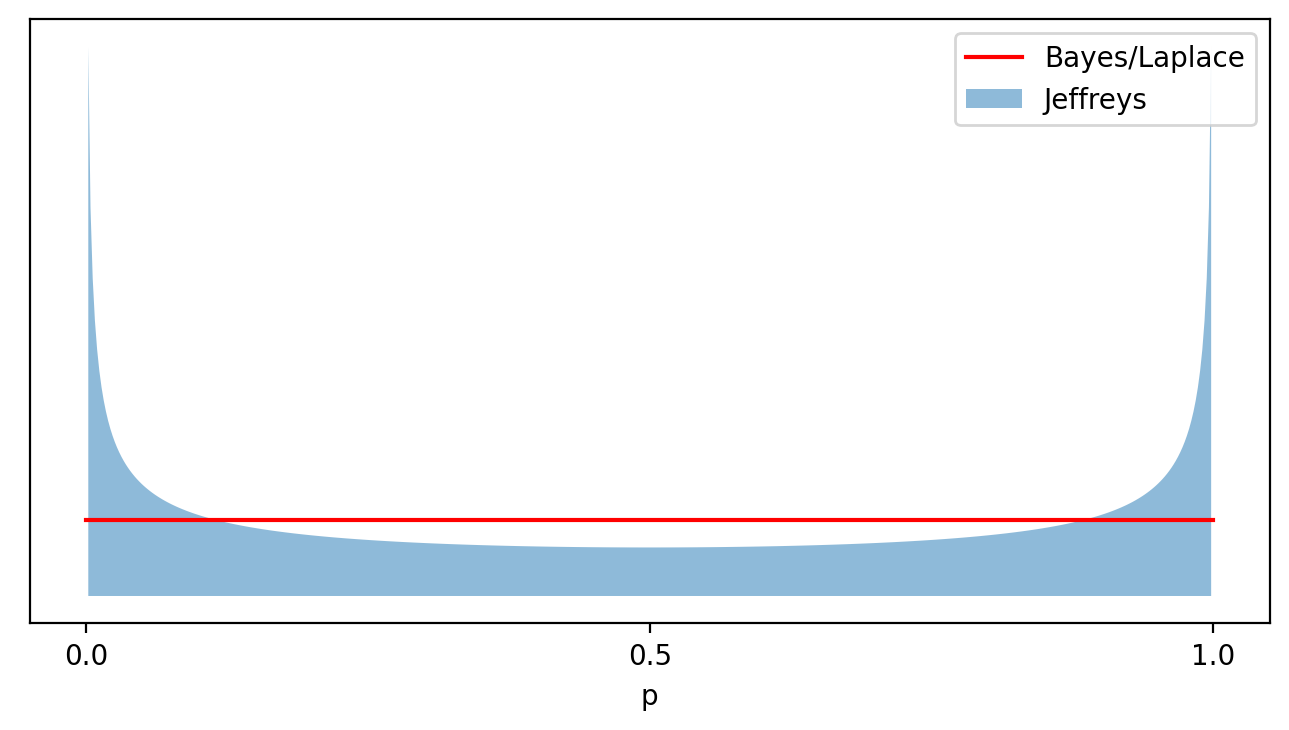

In [49]:
plt.figure(num=None, figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')

x = np.linspace(0,1,512)
plt.fill_between( x, beta.pdf( x, .5, .5 ), '-b', label='Jeffreys', alpha=0.5, where=[True]*len(x))
plt.plot( x, beta.pdf( x, 1, 1 ), '-r', label='Bayes/Laplace')

plt.xticks([0,.5,1])
plt.xlabel("p")
plt.yticks([])
plt.legend()

plt.show()

Figure \ref{fig:bayes_jeff_priors} shows the Bayes/Laplace prior ($\alpha = \beta = 1$) as well as the Jeffreys prior ($\alpha = \beta = \frac 1 2$). Both are inappropriate, for the reasons I gave when critiquing the PE report.bm

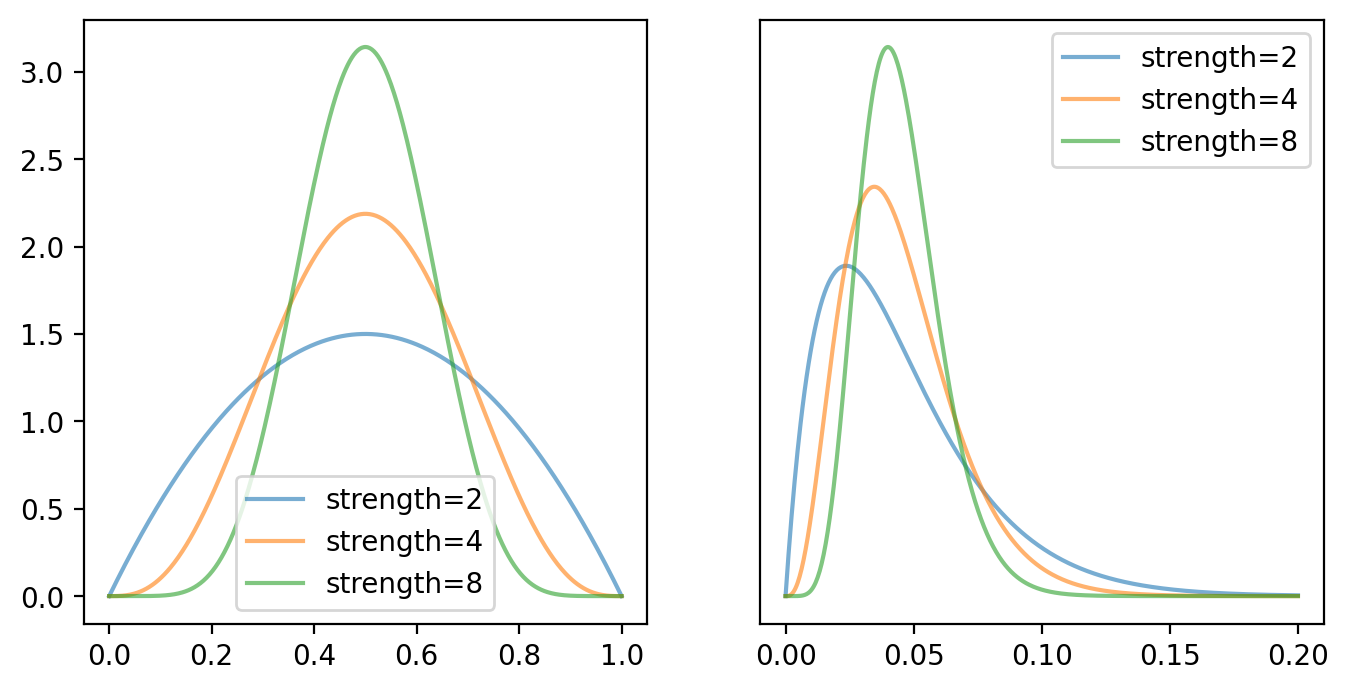

In [76]:
fig = plt.figure(figsize=(8, 4), dpi=dpi, facecolor='w', edgecolor='k')
(ax1, ax2) = fig.subplots(1, 2)

x = np.linspace(0,1,512)

scales = [2,4,8]
labels = [f'strength={scale}' for scale in scales]
r_blaze = Fraction(1,2)
r_pearl = Fraction(20,423)

for i,scale in enumerate(scales):

    ax1.plot(x, beta.pdf(x, scale, scale), '-', alpha=0.6, label=labels[i] )
    plt.yticks([])
    ax2.plot(x/5, beta.pdf(x/5, scale, float(scale/r_pearl)), '-', alpha=0.6, label=labels[i] )
    plt.yticks([])

ax1.legend()
ax2.legend()
plt.show()

The collection of priors in Figure \ref{fig:my_priors} satisfy my criticsms

## Attempt 2, this time via Conjugate Priors

$$ \text{NegBinom}(n,k,p) = p \cdot \text{Binom}(n-1,k-1,p) $$

$$ \text{Beta}(\alpha_\text{prior}, \beta_\text{prior},p) \cdot p^c \prod_{j=1}^c \text{Binom}(n_j-1,k_j-1,p) $$

$$ p^c \left( \text{Beta}(\alpha_\text{prior}, \beta_\text{prior},p) \cdot \prod_{j=1}^c \text{Binom}(n_j-1,k_j-1,p) \right) $$

$$ p^c \cdot \text{Beta}\left( \alpha_\text{prior} + \sum_{j=1}^{c} k_j - 1, \beta_\text{prior} + \sum_{j=1}^{c} n_j - 1 - (k_j - 1), p \right) $$

$$ n - 1 - (k - 1) = n - 1 - k + 1 = n - k $$

$$ \sum_{j=1}^c n_j - k_j = (\sum_{j=1}^c n_j) - (\sum_{j=1}^c k_j) $$

$$ \sum_{j=1}^c k_j - 1 = -c + \sum_{j=1}^c k_j $$

$$ \sum_{j=1}^c n_j = \|n\|_1 $$

$$ p^c \cdot \text{Beta}\left( \alpha_\text{prior} + \|k\|_1 - c, \beta_\text{prior} + \|n\|_1 - \|k\|_1, p \right) $$

$$ p^c \frac{\Gamma(\alpha_\text{prior} + \|k\|_1 - c + \beta_\text{prior} + \|n\|_1 - \|k\|_1)}{\Gamma(\alpha_\text{prior} + \|k\|_1 - c)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - c - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } $$

$$ p^a \cdot p^b = p^{a + b} $$

$$ \frac{\Gamma(\alpha_\text{prior} - c + \beta_\text{prior} + \|n\|_1)}{\Gamma(\alpha_\text{prior} + \|k\|_1 - c)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } $$

$$ \frac{ \frac{\Gamma(\alpha_\text{prior} - c + \beta_\text{prior} + \|n\|_1)}{\Gamma(\alpha_\text{prior} + \|k\|_1 - c)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } }{ \int_{p=0}^1 \frac{\Gamma(\alpha_\text{prior} - c + \beta_\text{prior} + \|n\|_1)}{\Gamma(\alpha_\text{prior} + \|k\|_1 - c)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } } $$

$$ \frac{ p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } }{ \int_{p=0}^1  p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } } $$

$$ \int_{p=0}^1 \text{Beta}(\alpha,\beta,p) = \int_{p=0}^1 \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1} (1-p)^{\beta-1} = 1 $$

$$ \int_{p=0}^1 p^{\alpha-1} (1-p)^{\beta-1} = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} $$

$$ \alpha - 1 = \alpha_\text{prior} + \|k\|_1 - 1 $$

$$ \beta - 1 = \beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 $$

$$ \frac{ p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } }{ \frac{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)}{ \Gamma(\alpha_\text{prior} + \|k\|_1) + \beta_\text{prior} + \|n\|_1 - \|k\|_1) } } = \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } $$

$$ \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } = \text{Beta}( \alpha_\text{prior} + \|k\|_1 , \beta_\text{prior} + \|n\|_1 - \|k\|_1, p )$$

$$ H_\text{fair} = \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p ) $$

$$ \mathcal{L}( H_\text{fair} | k, n ) = \int_{p=0}^1 \text{Beta}( \alpha_\text{prior} + \|k\|_1 , \beta_\text{prior} + \|n\|_1 - \|k\|_1, p ) \cdot \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p ) $$

$$ Pr( H_\text{fair} | k, n ) = \frac{ \int_{p=0}^1 \text{Beta}( \alpha_\text{prior} + \|k\|_1 , \beta_\text{prior} + \|n\|_1 - \|k\|_1, p ) \cdot \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p ) }{ \int_{p=0}^1 \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p )^2 } $$

$$ \text{Beta}( \alpha_\text{prior} + \|k\|_1 , \beta_\text{prior} + \|n\|_1 - \|k\|_1, p ) \cdot \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p ) = \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} p^{\alpha_\text{prior} + \|k\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 } \cdot \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} p^{\alpha_\text{prior} + r\|n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r)\|n\|_1 - 1 } $$

$$ \text{Beta}( \alpha_\text{prior} + r_\text{fair}\|n\|_1, \beta_\text{prior} + (1-r_\text{fair})\|n\|_1, p )^2 = \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} p^{\alpha_\text{prior} + r\|n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r)\|n\|_1 - 1 } \frac{ \Gamma(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1) }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} p^{\alpha_\text{prior} + r\|n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r)\|n\|_1 - 1 } $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} \int_{p=0}^1 p^{\alpha_\text{prior} + \|k\|_1 - 1 + \alpha_\text{prior} + r\|n\|_1 - 1} (1-p)^{\beta_\text{prior} + \|n\|_1 - \|k\|_1 - 1 + \beta_\text{prior} + (1-r)\|n\|_1 - 1 } $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} \int_{p=0}^1 p^{2 \alpha_\text{prior} + \|k\|_1 + r\|n\|_1 - 2} (1-p)^{2\beta_\text{prior} + (2-r)\|n\|_1 - \|k\|_1 - 2 } $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} \frac{\Gamma(2 \alpha_\text{prior} + \|k\|_1 + r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + (2-r)\|n\|_1 - \|k\|_1 - 1)}{\Gamma(2 \alpha_\text{prior} + \|k\|_1 + r\|n\|_1 - 1 + 2\beta_\text{prior} + (2-r)\|n\|_1 - \|k\|_1 - 1)} $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1)} \frac{\Gamma(2 \alpha_\text{prior} + \|k\|_1 + r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + (2-r)\|n\|_1 - \|k\|_1 - 1)}{\Gamma\left(2( \alpha_\text{prior} + \beta_\text{prior} + \|n\|_1 - 1)\right)} $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} \int_{p=0}^1 p^{\alpha_\text{prior} + r\|n\|_1 - 1 + \alpha_\text{prior} + r\|n\|_1 - 1} (1-p)^{\beta_\text{prior} + (1-r)\|n\|_1 - 1  + \beta_\text{prior} + (1-r)\|n\|_1 - 1} $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} \int_{p=0}^1 p^{2\alpha_\text{prior} + 2r\|n\|_1 - 2} (1-p)^{2\beta_\text{prior} + 2(1-r)\|n\|_1 - 2} $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} \frac{\Gamma(2\alpha_\text{prior} + 2r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + 2(1-r)\|n\|_1 - 1)}{\Gamma(2\alpha_\text{prior} + 2r\|n\|_1 - 1 + 2\beta_\text{prior} + 2(1-r)\|n\|_1 - 1)} $$

$$ \frac{ 1 }{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1)} \frac{\Gamma(2\alpha_\text{prior} + 2r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + 2(1-r)\|n\|_1 - 1)}{\Gamma\left(2(\alpha_\text{prior} + \beta_\text{prior} + \|n\|_1 - 1)\right)} $$

$$ Pr( H_\text{fair} | k, n ) = \frac{\Gamma(\alpha_\text{prior} + r\|n\|_1)\Gamma(\beta_\text{prior} + (1-r)\|n\|_1) }{\Gamma(\alpha_\text{prior} + \|k\|_1)\Gamma(\beta_\text{prior} + \|n\|_1 - \|k\|_1) } \frac{\Gamma(2 \alpha_\text{prior} + \|k\|_1 + r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + (2-r)\|n\|_1 - \|k\|_1 - 1)}{\Gamma(2\alpha_\text{prior} + 2r\|n\|_1 - 1)\Gamma(2\beta_\text{prior} + 2(1-r)\|n\|_1 - 1)}$$

In [ ]:
def prob_H_fair_INCOMPLETE( vec_k, vec_n, r_fair, a_prior, b_prior ):
    """Calculate the probability of someone playing fairly, according to H_fair.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total, list, or tuple containing the successful attempts at this task until it was completed.
    vec_n: A total, list, or tuple containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha component of the prior.
    b_prior: A positive or zero float representing the beta component of the prior.
    
    Returns
    -------
    The probability, an mpmath float in the range [0,1]."""
    
    from mpmath import gammaprod, fmul, fdiv
    from numpy import ndarray,sum        # vectorized
    from pandas.core.series import Series as series
    
    assert (r_fair > 0) and (r_fair < 1)
    assert (a_prior >= 0) and (b_prior >= 0)
    
    k_is_list = isinstance( vec_k, (list,tuple,ndarray,series) )
    n_is_list = isinstance( vec_n, (list,tuple,ndarray,series) )
    
    if k_is_list and n_is_list:
        assert len(vec_k) == len(vec_n)
        for i,n in enumerate(vec_n):
            assert n > 0
            assert vec_k[i] >= 0
            assert vec_k[i] <= n
        
    # calculate the sums
    if n_is_list:
        sum_n = sum(vec_n)
    else:
        sum_n = vec_n
    if k_is_list:
        sum_k = sum(vec_k)
    else:
        sum_k = vec_k
    
    assert sum_k <= sum_n

    numerator =   [a_prior + r_fair*sum_n, b_prior + (1-r_fair)*sum_n,
                   2*a_prior + sum_k + r_fair*sum_n - 1,
                   2*b_prior + (2 - r_fair)*sum_n - sum_k - 1]
    denominator = [a_prior + sum_k, b_prior + sum_n - sum_k,
                   2*a_prior + 2*r_fair*sum_n - 1,
                   2*b_prior + 2*(1 - r_fair)*sum_n - 1]
    
    return gammaprod(numerator, denominator)

In [ ]:
n = 12
r_fair = 0.5
a_prior = 4
b_prior = 2 / r_fair

x = list(range(n+1))
fig = px.bar( x=x, y=[float(prob_H_fair_INCOMPLETE(v, n, r_fair, a_prior, b_prior)) for v in x] )

fig.update_layout(title=f"I hunted Blaze rods {n} times, what are the odds I gathered them honestly?")
fig.update_xaxes(title="Blaze rods dropped")
fig.update_yaxes(title="Probability")

fig_show()

In [ ]:
mean    = 9.2
stdev   = 3.6
r_cheat = 0.55
r_fair  = 0.5
count   = 150

n       = np.array(np.maximum( random.standard_normal(count)*stdev + mean + .5, 2 ),dtype='int64')
cheat_k = random.binomial( n-1, r_cheat ) + 1 
fair_k  = random.binomial( n-1, r_fair ) + 1

sum_n       = np.cumsum( n )
sum_cheat_k = np.cumsum( cheat_k )
sum_fair_k  = np.cumsum( fair_k )

cheat_y = [float(prob_H_fair_INCOMPLETE(sum_cheat_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]
fair_y  = [float(prob_H_fair_INCOMPLETE(sum_fair_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]

x = list(range(1,count+1))
fig = go.Figure()
fig.add_trace( go.Scatter(x=x, y=cheat_y, name='cheater', mode='lines') )
fig.add_trace( go.Scatter(x=x, y=fair_y, name='fair', mode='lines') )

fig.update_layout(title=f"Probability behaviour for a cheater (r={r_cheat}) vs. someone playing fair (r={r_fair}).")
fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()

In [ ]:
n       = np.array(np.maximum( random.standard_normal(count)*stdev + mean + .5, 2 ),dtype='int64')
cheat_k = random.binomial( n-1, r_cheat ) + 1 
fair_k  = random.binomial( n-1, r_fair ) + 1

x           = np.arange(1, count+1)
sum_n       = np.cumsum( n ) - x
sum_cheat_k = np.cumsum( cheat_k ) - x
sum_fair_k  = np.cumsum( fair_k ) - x

cheat_y = [float(prob_H_fair_INCOMPLETE(sum_cheat_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]
fair_y  = [float(prob_H_fair_INCOMPLETE(sum_fair_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]


fig = go.Figure()
fig.add_trace( go.Scatter(x=x, y=cheat_y, name='cheater', mode='lines') )
fig.add_trace( go.Scatter(x=x, y=fair_y, name='fair', mode='lines') )

fig.update_layout(title=f"Probability behaviour for a cheater (r={r_cheat}) vs. someone playing fair (r={r_fair})," + \
                  "<br> but with an adjustment to ensure that data is binomial.")
fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()

In [ ]:
def prob_H_fair( vec_k, vec_n, r_fair, a_prior, b_prior, negbinom=False ):
    """Calculate the probability of someone playing fairly, according to H_fair.
        Relies on mpmath to perform all calculations, which also means you can adjust the precision.
    
    Parameters
    ----------
    vec_k: A total or list containing the successful attempts at this task until it was completed.
    vec_n: A total or list containing the total attempts at this task until it was completed.
    r_fair: A float between 0 and 1 representing the probability of success predicted by H_fair.
    a_prior: A positive or zero float representing the alpha component of the prior.
    b_prior: A positive or zero float representing the beta component of the prior.
    negbinom: A boolean value that toggles whether or not k and n are distributed according to the
       negative binomial distribution (True) or the binomial. This cannot be True if both k and n
       are totals.
    
    Returns
    -------
    The probability, an mpmath float in the range [0,1]."""

    # place some imports here to encourage copy-paste coding
    from mpmath import gammaprod
    from numpy import sum        # vectorized, likely faster than Python's sum
    
    assert (r_fair > 0) and (r_fair < 1)
    assert (a_prior >= 0) and (b_prior >= 0)
    
    # use duck typing to determine whether these are lists or not
    try:
        len_k = len(vec_k)
        k_is_list = True
    except TypeError:
        len_k = 1
        k_is_list = False

    try:
        len_n = len(vec_n)
        n_is_list = True
    except TypeError:
        len_n = 1
        n_is_list = False
   
    length = max(len_k, len_n)
    
    # can't correct the inputs if both of them are numbers
    assert k_is_list or n_is_list or not negbinom
    
    # do additional checks if both are lists
    if (len_k > 1) and (len_n > 1):
        
        assert len_k == len_n
        for i,n in enumerate(vec_n):
            assert n > 0
            assert vec_k[i] >= 0
            assert vec_k[i] <= n
            
    # work out any offset, due to negative binomial compensation
    if negbinom:
        offset = length
    else:
        offset = 0
        
    # now calculate sums
    if n_is_list:
        sum_n = sum(vec_n) - offset
    else:
        sum_n = vec_n - offset
        
    if k_is_list:
        sum_k = sum(vec_k) - offset
    else:
        sum_k = vec_k - offset
        
    # one final round of checks
    assert sum_n > 1
    assert (sum_k >= 0) and (sum_k <= sum_n)

    # calculate the final result
    numerator =   [a_prior + r_fair*sum_n, b_prior + (1-r_fair)*sum_n,
                   2*a_prior + sum_k + r_fair*sum_n - 1,
                   2*b_prior + (2 - r_fair)*sum_n - sum_k - 1]
    denominator = [a_prior + sum_k, b_prior + sum_n - sum_k,
                   2*a_prior + 2*r_fair*sum_n - 1,
                   2*b_prior + 2*(1 - r_fair)*sum_n - 1]
    
    return gammaprod(numerator, denominator)

In [ ]:
r_fair    = 0.5
r_cheat_h = 0.55
r_cheat_l = 0.45

n         = np.array(np.maximum( random.standard_normal(count)*stdev + mean + .5, 2 ),dtype='int64')
cheat_h_k = random.binomial( n-1, r_cheat_h ) + 1 
cheat_l_k = random.binomial( n-1, r_cheat_l ) + 1 
fair_k    = random.binomial( n-1, r_fair ) + 1

cheat_h_y = [float(prob_H_fair(cheat_h_k[:i], n[:i], r_fair, a_prior, b_prior, negbinom=True)) for i in x]
cheat_l_y = [float(prob_H_fair(cheat_l_k[:i], n[:i], r_fair, a_prior, b_prior, negbinom=True)) for i in x]
fair_y  = [float(prob_H_fair(fair_k[:i], n[:i], r_fair, a_prior, b_prior, negbinom=True)) for i in x]


fig = go.Figure()
fig.add_trace( go.Scatter(x=x, y=cheat_h_y, name=f'cheater (r={r_cheat_h})', mode='lines') )
fig.add_trace( go.Scatter(x=x, y=cheat_l_y, name=f'cheater (r={r_cheat_l})', mode='lines') )
fig.add_trace( go.Scatter(x=x, y=fair_y, name='fair', mode='lines') )

fig.update_layout(title=f"Probability behaviour for two cheaters vs. someone playing fair (r={r_fair})," + \
                  "<br> but with an adjustment to ensure that data is binomial.")
fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()

In [ ]:
mean    = 15
stdev   = 9.35
r_cheat = 30/423
r_fair  = 20/423
a_prior = 4
b_prior = 2 / r_fair
count   = 150

n       = np.array(np.maximum( random.standard_normal(count)*stdev + mean + .5, 2 ),dtype='int64')
cheat_k = random.binomial( n-1, r_cheat ) + 1 
fair_k  = random.binomial( n-1, r_fair ) + 1

x           = np.arange(1, count+1)
sum_n       = np.cumsum( n ) - x
sum_cheat_k = np.cumsum( cheat_k ) - x
sum_fair_k  = np.cumsum( fair_k ) - x

cheat_y = [float(prob_H_fair(sum_cheat_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]
fair_y  = [float(prob_H_fair(sum_fair_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]


fig = go.Figure()
fig.add_trace( go.Scatter(x=x, y=cheat_y, name='cheater', mode='lines') )
fig.add_trace( go.Scatter(x=x, y=fair_y, name='fair', mode='lines') )

fig.update_layout(title=f"Probability behaviour for a cheater (r={r_cheat}) vs. someone playing fair (r={r_fair})," + \
                  "<br> but with an adjustment to ensure that data is binomial.")
fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()

In [ ]:
players = ['benex','dream','illumina','sizzler','vadikus007']

bartering  = dict()
blaze_rods = dict()

for p in players:
    bartering[p]  = pd.read_csv(f'data/bartering.{p}.tsv',sep="\t")
    blaze_rods[p] = pd.read_csv(f'data/blaze.{p}.tsv',sep="\t")

bartering['dream'].tail()

In [ ]:
fig = go.Figure()
r_fair = 0.5
a_prior = 4
b_prior = 2 / r_fair

for p in players:
    
    count = len(blaze_rods[p])
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( blaze_rods[p]['n'] ) - x
    sum_k = np.cumsum( blaze_rods[p]['k'] ) - x

    y = [float(prob_H_fair(sum_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]
    fig.add_trace( go.Scatter(x=x, y=y, name=p, mode='lines') )

fig.update_layout(title=f"Probabilities for Blaze rod drops (r={r_fair})," + \
                    "<br> but with an adjustment to ensure that the data is binomial.")

fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()

In [ ]:
fig = go.Figure()
r_fair = 20/423
a_prior = 4
b_prior = 2 / r_fair

for p in players:
    
    count = len(bartering[p])
    x     = np.arange(1, count+1)
    sum_n = np.cumsum( bartering[p]['n'] ) - x
    sum_k = np.cumsum( bartering[p]['k'] ) - x

    y = [float(prob_H_fair(sum_k[i], n, r_fair, a_prior, b_prior)) for i,n in enumerate(sum_n)]
    fig.add_trace( go.Scatter(x=x, y=y, name=p, mode='lines') )

fig.update_layout(title=f"Probabilities for Piglin bartering drops (r={r_fair})," + \
                    "<br> but with an adjustment to ensure that data is binomial.")

fig.update_xaxes(title="Rounds")
fig.update_yaxes(title='Probability',type="log")

fig_show()